In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')
from film import FilmSimple
from spectrum import Spectrum
from design import Design

from analyze_utils.structure import plot_layer_thickness
from optimizer.adam import adam_optimize
import pickle



In [4]:
def make_edgefilter_design(init_film: FilmSimple):
    inc_ang = 0.
    wls = np.linspace(400, 1000, 500) # when wls = 50, ~100 min
    # R = np.ones(wls.shape[0] , dtype='float')
    R = np.zeros(wls.shape[0] , dtype='float')
    R[wls.shape[0] // 2:] = 1.
    target_spec = [Spectrum(inc_ang, wls, R)]
    
    design = Design(target_spec, init_film)
    return design


def make_reflection_design(init_film: FilmSimple):
    inc_ang = 0.
    # wls = np.linspace(700, 800, 500) # when wls = 50, ~100 min
    wls = np.linspace(695, 939, 500) # DBR
    R = np.ones(wls.shape[0] , dtype='float')
    target_spec = [Spectrum(inc_ang, wls, R)]
    
    design = Design(target_spec, init_film)
    return design

def make_three_line_filter_design(init_film: FilmSimple):
    inc_ang = 0.
    def make_r_spec(wl_1, wl_2):
        wls = np.linspace(wl_1, wl_2, 2 * int(wl_2 - wl_1))
        R = np.ones(wls.shape[0] , dtype='float')
        return R
    def make_t_spec(wl_1, wl_2):
        wls = np.linspace(wl_1, wl_2, 2 * int(wl_2 - wl_1))
        R = np.zeros(wls.shape[0] , dtype='float')
        return R
    make_wl = lambda x1, x2: np.linspace(x1, x2, 2 * int(x2 - x1), dtype='float')
    
    wls, R = np.array([]), np.array([])
    
    wls = np.append(wls, make_wl(400, 440))
    R = np.append(R, make_r_spec(400, 440))

    wls = np.append(wls, make_wl(445, 455))
    R = np.append(R, make_t_spec(445, 455))

    wls = np.append(wls, make_wl(460, 500))
    R = np.append(R, make_r_spec(460, 500))
    
    wls = np.append(wls, make_wl(505, 515))
    R = np.append(R, make_t_spec(505, 515))

    wls = np.append(wls, make_wl(520, 630))
    R = np.append(R, make_r_spec(520, 630))
    
    wls = np.append(wls, make_wl(635, 645))
    R = np.append(R, make_t_spec(635, 645))
    
    wls = np.append(wls, make_wl(650, 700))
    R = np.append(R, make_r_spec(650, 700))

    target_spec = [Spectrum(inc_ang, wls, R)]
    
    design = Design(target_spec, init_film)
    return design



In [ ]:

init_ots = np.arange(1, 20000, 100)
layer_numbers = np.arange(40, 200, 50)
rep_numbers = np.arange(3)

for init_ot in init_ots:
    for rep in rep_numbers:

        for layer_number in layer_numbers:
            np.random.seed(rep)
            d = np.random.random(layer_number)
            init_film = FilmSimple('SiO2', 'TiO2', 'SiO2', d)
            d *= init_ot / (init_film.get_optical_thickness(700.)) # roughly 1000 nm ot
            
            design = make_reflection_design(init_film)
            losses = adam_optimize(design.film, design.target_specs, 5000, alpha=1, show=False, record=True)
            
            fname = f'./raw_result/back_reflector/SiO2_TiO2-700to800nm-700nm/ot{init_ot}_layer{layer_number}_rep{rep}_design.pkl'
            with open(fname, 'wb') as f:
                pickle.dump(design, f)

0.08188497010455226
1991.697019708768
2430.974257268008
17


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(<AxesSubplot: title={'center': 'refractive index distribution at  701 nm'}, xlabel='position / nm'>,
 <Figure size 600x100 with 1 Axes>)

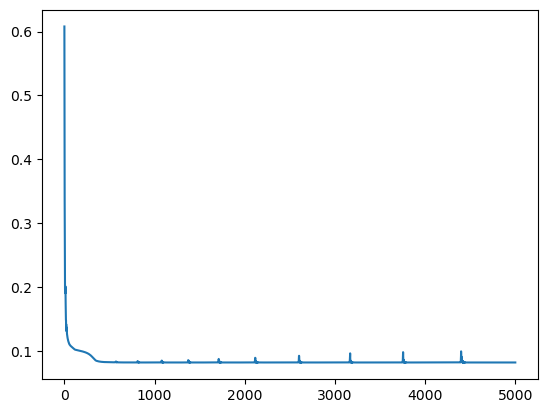

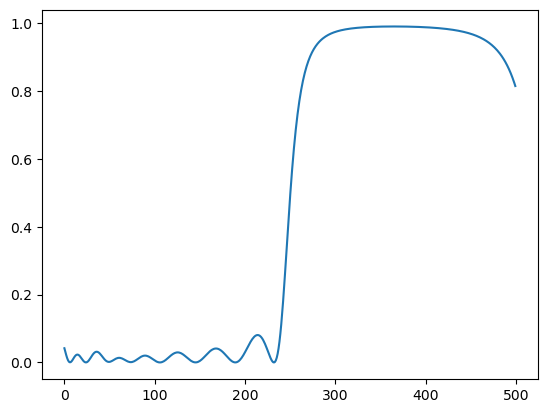

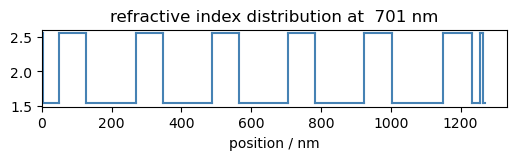

In [3]:
print(design.calculate_loss())
print(design.get_init_ot())
print(design.get_current_ot())
design.film.remove_negative_thickness_layer()
print(design.film.get_layer_number())

import matplotlib.pyplot as plt
plt.plot(losses)

fig, ax = plt.subplots(1, 1)
ax.plot(design.film.get_spec().get_R())

plot_layer_thickness(design.film)


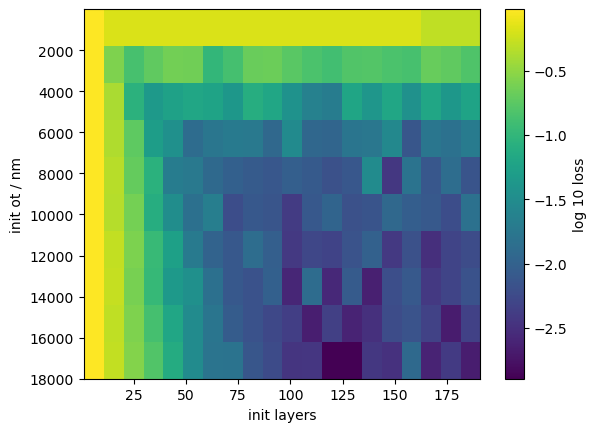

In [17]:
init_ots = np.arange(1, 20000, 2000)
layer_numbers = np.arange(1, 200, 10)
rep_number = 3

rep = 2


loss_arr: list[list[float]] = []
for init_ot in init_ots:
    loss_arr.append([])
    for layer_number in layer_numbers:
        fname = f'./raw_result/back_reflector/SiO2_TiO2-400to1000nm-700nm/ot{init_ot}_layer{layer_number}_rep{rep}_design.pkl'
        with open(fname, 'rb') as f:
            design: Design = pickle.load(f)
        loss_arr[-1].append(design.calculate_loss())


fig, ax = plt.subplots(1, 1)
s = ax.imshow(
    np.log10(loss_arr), 
    aspect='auto', 
    extent=[layer_numbers[0], layer_numbers[-1], init_ots[-1], init_ots[0]], 
        
)
ax.set_xlabel('init layers')
ax.set_ylabel('init ot / nm')
cbar = fig.colorbar(s)
cbar.set_label('log 10 loss')



Text(0, 0.5, 'final layer number (zero thickness removed)')

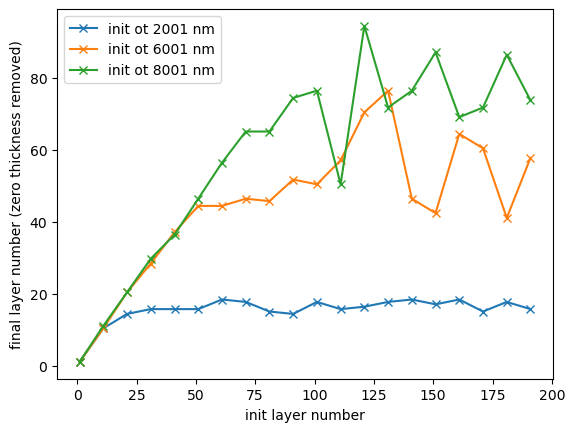

In [46]:
rep_number = 3
init_layer = []
final_layer = []
for init_ot in init_ots:
    init_layer.append([])
    final_layer.append([])
    for layer_number in layer_numbers:
        avg_init_layer_num = 0
        avg_final_layer_num = 0
        for rep in range(rep_number):
            fname = f'./raw_result/back_reflector/SiO2_TiO2-400to1000nm-700nm/ot{init_ot}_layer{layer_number}_rep{rep}_design.pkl'
            with open(fname, 'rb') as f:
                design: Design = pickle.load(f)
            design.film.remove_negative_thickness_layer()
            avg_init_layer_num += design.init_film.get_layer_number() / rep_number
            avg_final_layer_num += design.film.get_layer_number() / rep_number
        init_layer[-1].append(avg_init_layer_num)
        final_layer[-1].append(avg_final_layer_num)


fig, ax = plt.subplots(1, 1)
for init_ot, init_layer_ls, final_layer_ls in zip(init_ots, init_layer, final_layer):
    if init_ot not in [2001, 6001, 8001, 18001]:
        continue
    ax.plot(init_layer_ls, final_layer_ls, marker='x', label=f'init ot {init_ot} nm')
ax.legend()
ax.set_xlabel('init layer number')
ax.set_ylabel('final layer number (zero thickness removed)')

Text(0, 0.5, 'final ot')

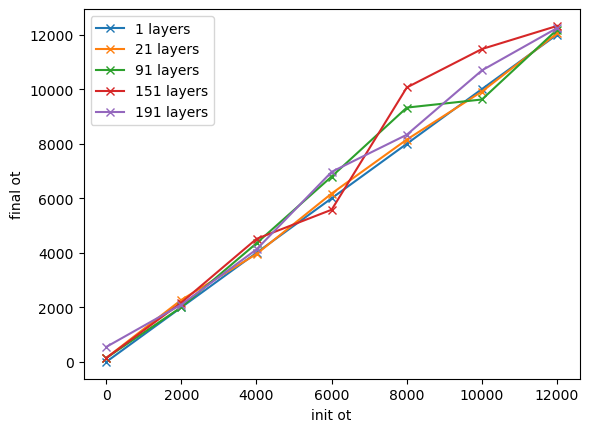

In [55]:
rep_number = 3
final_ot = []
for layer_number in layer_numbers:
    final_ot.append([])
    for init_ot in init_ots:
        avg_init_ot = 0
        avg_final_ot = 0
        for rep in range(rep_number):
            fname = f'./raw_result/back_reflector/SiO2_TiO2-400to1000nm-700nm/ot{init_ot}_layer{layer_number}_rep{rep}_design.pkl'
            with open(fname, 'rb') as f:
                design: Design = pickle.load(f)
            design.film.remove_negative_thickness_layer()
            avg_init_ot += design.init_film.get_optical_thickness(700.) / rep_number
            avg_final_ot += design.film.get_optical_thickness(700.) / rep_number
        final_ot[-1].append(avg_final_ot)


fig, ax = plt.subplots(1, 1)
for layer_number, final_ot_ls in zip(layer_numbers, final_ot):
    if layer_number not in [1, 21, 91, 151, 191]:
        continue

    ax.plot(init_ots, final_ot_ls, marker='x', label=f'{layer_number} layers')
ax.legend()
ax.set_xlabel('init ot')
ax.set_ylabel('final ot')

In [21]:
# load gd design
init_ots = np.arange(1, 14000, 2000)
layer_number = 151
rep_number = 3
losses = [[] for _ in range(rep_number)]
for init_ot in init_ots:    
    for rep in range(rep_number):
        fname = f'./raw_result/back_reflector/SiO2_TiO2-400to1000nm-700nm/ot{init_ot}_layer{layer_number}_rep{rep}_design.pkl'
        with open(fname, 'rb') as f:
            design: Design = pickle.load(f)
        losses[rep].append(design.calculate_loss())

# load needle design
losses_needle = []
init_ots_needle = []
for run_num in range(1, 151):
    fname = f'./../needle_training/raw_result/single_inc/reflection-0_inc-400to1000wls-init_single_layer_SiO2/{run_num}_design.pkl'
    with open(fname, 'rb') as f:
        design = pickle.load(f)
        losses_needle.append(design.calculate_loss())
        init_ots_needle.append(design.get_init_ot())
# load randomly initialized needle design
losses_needle_10 = []
init_ots_needle_10 = []
for run_num in range(1, 151):
    fname = f'./../needle_training/raw_result/single_inc/reflection-0_inc-400to1000wls-init_10_layer_SiO2/{run_num}_design.pkl'
    with open(fname, 'rb') as f:
        design = pickle.load(f)
        losses_needle_10.append(design.calculate_loss())
        init_ots_needle_10.append(design.get_init_ot())


[40.20993779132797, 78.88048011892484, 117.5510224465217, 156.22156477411855, 194.89210710171542, 233.5626494293123, 272.23319175690915, 310.903734084506, 349.5742764121029, 388.2448187396997, 426.9153610672966, 465.5859033948935, 504.2564457224903, 542.9269880500872, 581.597530377684, 620.2680727052809, 658.9386150328778, 697.6091573604747, 736.2796996880716, 774.9502420156684, 813.6207843432652, 852.2913266708621, 890.961868998459, 929.632411326056, 968.3029536536528, 1006.9734959812496, 1045.6440383088463, 1084.3145806364435, 1122.9851229640403, 1161.655665291637, 1200.3262076192339, 1238.9967499468307, 1277.6672922744276, 1316.3378346020245, 1355.0083769296214, 1393.6789192572182, 1432.3494615848151, 1471.020003912412, 1509.6905462400089, 1548.3610885676057, 1587.0316308952029, 1625.7021732227993, 1664.3727155503962, 1703.043257877993, 1741.71380020559, 1780.384342533187, 1819.054884860784, 1857.7254271883808, 1896.3959695159776, 1935.0665118435745, 1973.7370541711712, 2012.4075964

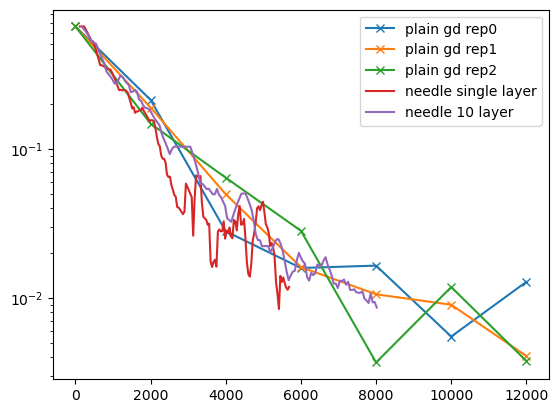

In [24]:
# plots

def moving_avg(x: list, y:list, N: int):
    y = np.array(y)
    l = len(x)
    y = [np.average(y[i: i + N]) for i in range(l - N)]
    return x[N // 2: -N + N // 2], np.array(y)

init_ots_needle_mvavg, losses_needle_mvavg = moving_avg(init_ots_needle, losses_needle, 5)
init_ots_needle_10_mvavg, losses_needle_10_mvavg = moving_avg(init_ots_needle_10, losses_needle_10, 5)
print(init_ots_needle)

fig, ax = plt.subplots(1, 1)
for rep in range(rep_number):
    ax.plot(init_ots, [x for x in losses[rep]], label=f'plain gd rep{rep}', marker='x')
ax.plot(init_ots_needle_mvavg, losses_needle_mvavg, label='needle single layer')
ax.plot(init_ots_needle_10_mvavg, losses_needle_10_mvavg, label='needle 10 layer')

ax.legend()
ax.set_yscale('log')
